In [133]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import models,layers,Sequential,preprocessing
from tensorflow.keras.layers import Conv2D,experimental,MaxPool2D,Flatten,Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as df

In [85]:
IMAGE_SIZE=256
BATCH_SIZE=32

In [86]:
dataset=preprocessing.image_dataset_from_directory(
    "./Potato Disease projects/PlantVillage",
    batch_size=BATCH_SIZE,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE)

)

Found 2152 files belonging to 3 classes.


In [87]:
len(dataset)

68

In [88]:
68*32

2176

In [89]:
classNames=dataset.class_names

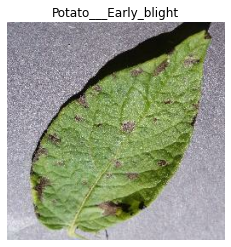

In [90]:
for image,label in dataset.take(1):
    plt.imshow(image.numpy()[0].astype("uint8"))
    plt.title(classNames[label[0]])
    plt.axis("off")

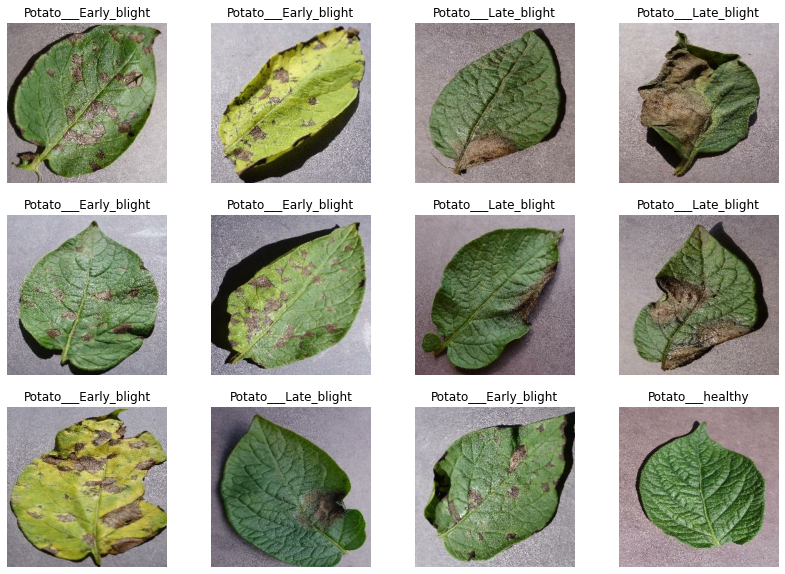

In [91]:
plt.figure(figsize=(14,10))
for image,label in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image.numpy()[i].astype("uint8"))
        plt.title(classNames[label[i]])
        plt.axis("off")

In [35]:
# 80% => Training
# 10% => Validation
# 10% => Testing

In [67]:
def get_training_testing_set(ds,training=0.8,validation=0.1,testing=0.1,shuffle=True,shuffle_batch=1000):
    if shuffle:
        ds=ds.shuffle(shuffle_batch)
    train_size=int(len(ds)*0.8)
    pending_ds=ds.skip(train_size)
    validation_ds=pending_ds.take(int(0.1*train_size))
    testing_ds=pending_ds.skip(len(validation_ds))
    training_ds=ds.take(train_size)
    return training_ds,validation_ds,testing_ds

In [68]:
training_ds,validation_ds,testing_ds=get_training_testing_set(dataset)

In [93]:
training_ds=training_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
validation_ds=validation_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
testing_ds=testing_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

In [96]:
resize_rescale=Sequential(
    [
    experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    experimental.preprocessing.Rescaling(1/255)
    ]
)
dataAugmantation=Sequential(
    [
    experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    experimental.preprocessing.RandomRotation(0)
])

In [97]:
32*256*256


2097152

In [107]:
INPUT_SHAPE=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE)
model=Sequential([
    resize_rescale,
    dataAugmantation,
    Conv2D(32,(3,3),activation="relu",input_shape=INPUT_SHAPE),
    MaxPool2D(pool_size=(3,3)),
    Conv2D(64,(3,3),activation="relu"),
    MaxPool2D(pool_size=(3,3)),
    Conv2D(64,(3,3),activation="relu"),
    MaxPool2D(pool_size=(3,3)),
    Conv2D(64,(3,3),activation="relu"),
    MaxPool2D(pool_size=(3,3)),
    Flatten(),
    Dense(32,activation="relu"),
    Dense(32,activation="relu"),
    Dense(len(classNames),activation="sigmoid"),
])

In [124]:
model.compile(optimizer="adam",loss=tf.losses.SparseCategoricalCrossentropy(),metrics=["accuracy"])
earlyStopping=EarlyStopping(monitor="val_loss",patience=2)

In [125]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 sequential_13 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 84, 84, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 82, 82, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 27, 27, 64)       0         
 2D)                                                 

In [127]:
result=model.fit(training_ds,
                 epochs=10,
                 batch_size=BATCH_SIZE,
                 validation_data=validation_ds,callbacks=[earlyStopping])

Epoch 1/10
54/54 [==============================] - 74s 1s/step - loss: 0.7458 - accuracy: 0.6150 - val_loss: 0.5741 - val_accuracy: 0.7312
Epoch 2/10
54/54 [==============================] - 66s 1s/step - loss: 0.6223 - accuracy: 0.7142 - val_loss: 0.6179 - val_accuracy: 0.7437
Epoch 3/10
54/54 [==============================] - 65s 1s/step - loss: 0.5021 - accuracy: 0.7858 - val_loss: 0.3086 - val_accuracy: 0.8625
Epoch 4/10
54/54 [==============================] - 66s 1s/step - loss: 0.2419 - accuracy: 0.8991 - val_loss: 0.0990 - val_accuracy: 0.9750
Epoch 5/10
54/54 [==============================] - 65s 1s/step - loss: 0.1717 - accuracy: 0.9354 - val_loss: 0.0822 - val_accuracy: 0.9688
Epoch 6/10
54/54 [==============================] - 66s 1s/step - loss: 0.1292 - accuracy: 0.9525 - val_loss: 0.0376 - val_accuracy: 0.9937
Epoch 7/10
54/54 [==============================] - 66s 1s/step - loss: 0.0911 - accuracy: 0.9665 - val_loss: 0.2180 - val_accuracy: 0.9250
Epoch 8/10
54/54 [==

In [128]:
model.evaluate(testing_ds)

9/9 [==============================] - 7s 330ms/step - loss: 0.0700 - accuracy: 0.9792


[0.07000771909952164, 0.9791666865348816]

In [134]:
result_df=df.DataFrame(result.history)

<AxesSubplot:>

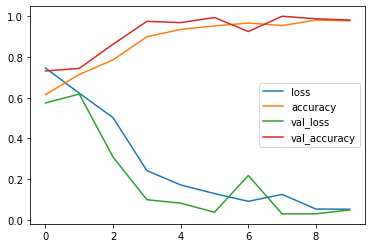

In [136]:
result_df.plot()

In [184]:
predictions=model.predict(testing_ds)
predictions

array([[9.99919772e-01, 1.37979090e-01, 1.63178333e-06],
       [7.57473707e-03, 9.95382845e-01, 9.18589115e-01],
       [1.00000000e+00, 7.76136220e-02, 4.93913868e-11],
       [5.73629141e-03, 9.99971509e-01, 4.16842401e-02],
       [9.96963441e-01, 1.68717027e-01, 4.54246998e-04],
       [9.99995112e-01, 2.27543384e-01, 8.74090578e-09],
       [9.99960959e-01, 1.31245553e-01, 1.29864065e-06],
       [9.99972224e-01, 1.10832304e-01, 3.77747938e-07],
       [1.00000000e+00, 1.98018312e-01, 1.22878071e-11],
       [1.00000000e+00, 2.57442892e-02, 6.16236839e-10],
       [3.20340097e-02, 9.97370005e-01, 1.85496449e-01],
       [3.86443734e-02, 9.97868061e-01, 1.66113138e-01],
       [9.99089122e-01, 2.70016015e-01, 2.08893543e-05],
       [1.00000000e+00, 6.57727122e-02, 1.49091971e-11],
       [1.17634833e-02, 9.96291935e-01, 6.86949372e-01],
       [9.99849916e-01, 7.01807320e-01, 1.86050315e-07],
       [4.85644251e-01, 9.99993086e-01, 7.24056974e-08],
       [9.99985337e-01, 1.98634

In [203]:
def getPredictions(image):
    img=image.numpy().reshape(-1,256,256,3)
    prediction=model.predict(img)
    perc=np.round(prediction.max()*100,2)
    perdictedValue=classNames[prediction.argmax()]
    return perdictedValue,perc;
    

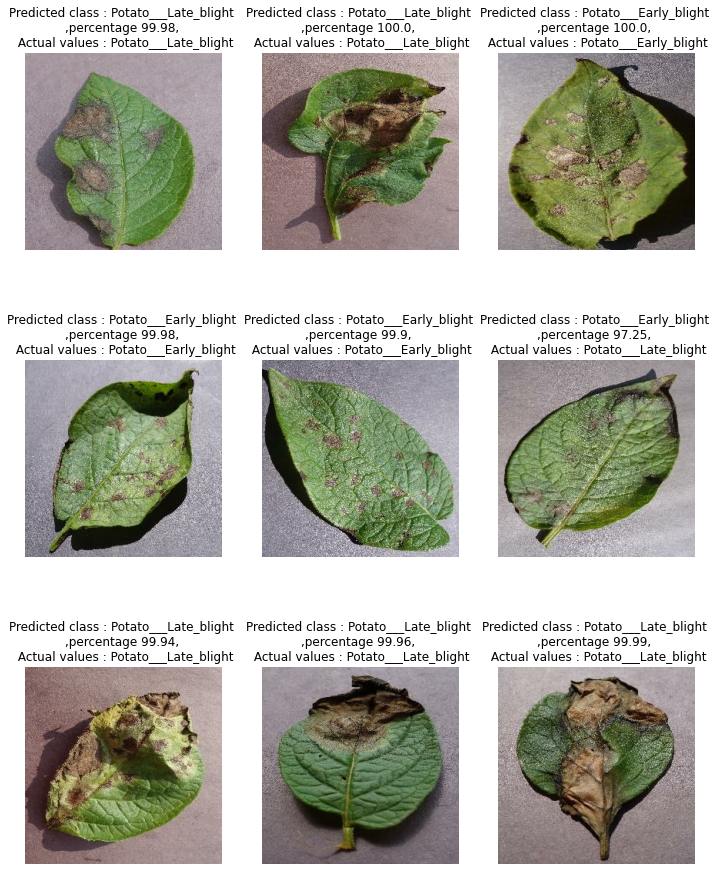

In [208]:
plt.figure(figsize=(12,16))
for image,label in testing_ds.take(1): #first batch
    for i in range(9): #only 4 from first batch
        plt.subplot(3,3,i+1)
        predictedValue,perc=getPredictions(image[i])
        plt.title(f"Predicted class : {predictedValue} \n,percentage {perc}, \n Actual values : {classNames[label[i]]}")    
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.axis("off")

In [217]:
version=1.0
model.save(f"./Potato Disease projects/model/version_{version}",save_format="h5")

In [219]:
loadedModel=tf.keras.models.load_model("./Potato Disease projects/model/version_1.0")

In [220]:
loadedModel.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 sequential_13 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 84, 84, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 82, 82, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 27, 27, 64)       0         
 2D)                                                 